# Data Analysis

* In order to solve this task, it is important to understand the foundation of the data
* This notebook's purpose is to analyze the data to...
  * find outlier
  * find the ration of missing values
  * find missing labels
  * check whether features are useful for forecasting

In [2]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt

## Read all data as pandas data frames

In [3]:
df_list = {}
for folder_name in ["Ohio2020", "Ohio2018"]:
    for r, d, f in os.walk(os.path.join("Ohio Data", folder_name, "train")):
        for file in f:
            df_list[file] = pd.read_csv(os.path.join(r, file))

In [4]:
all_data = pd.concat(df_list.values(), ignore_index=True)

In [5]:
cols = all_data.columns

## Print the statistics of missing labels and missing values

In [6]:
print("Statistics\n")
for key, df in df_list.items():
    print(f"{key}: missing cbg values: {(df['missing_cbg'].sum() / df.shape[0] * 100):.2f}%")

print()

print(f"Total missing cbg values: {(all_data['missing_cbg'].sum() / all_data.shape[0] * 100):.2f}%")

print("Other 'NA' values")
for col in cols:
    print(f"Missing {col} values: {all_data[col].isna().sum() / all_data.shape[0]}")

Statistics

567-ws-training_processed.csv: missing cbg values: 19.78%
540-ws-training_processed.csv: missing cbg values: 8.87%
584-ws-training_processed.csv: missing cbg values: 8.29%
596-ws-training_processed.csv: missing cbg values: 20.19%
552-ws-training_processed.csv: missing cbg values: 18.18%
544-ws-training_processed.csv: missing cbg values: 16.16%
588-ws-training_processed.csv: missing cbg values: 3.55%
563-ws-training_processed.csv: missing cbg values: 7.43%
575-ws-training_processed.csv: missing cbg values: 9.44%
559-ws-training_processed.csv: missing cbg values: 10.63%
591-ws-training_processed.csv: missing cbg values: 14.96%
570-ws-training_processed.csv: missing cbg values: 5.42%

Total missing cbg values: 11.93%
Other 'NA' values
Missing 5minute_intervals_timestamp values: 0.0
Missing missing_cbg values: 0.0
Missing cbg values: 0.11925718280961062
Missing finger values: 0.97525467364528
Missing basal values: 0.008429223923313665
Missing hr values: 0.53765380066519
Missing

567-ws-training_processed.csv


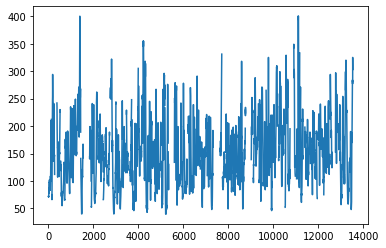

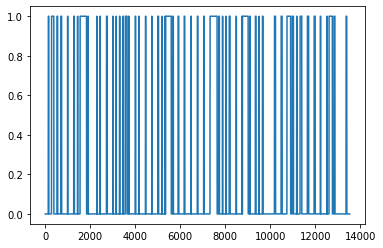

540-ws-training_processed.csv


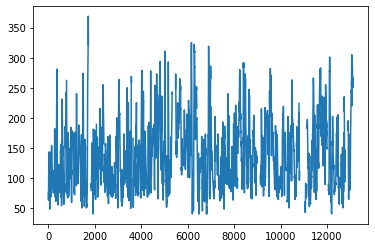

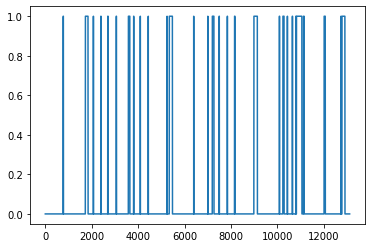

584-ws-training_processed.csv


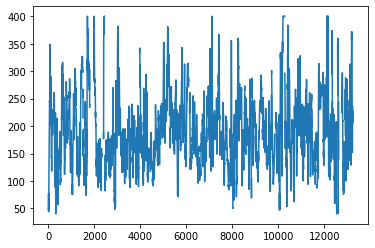

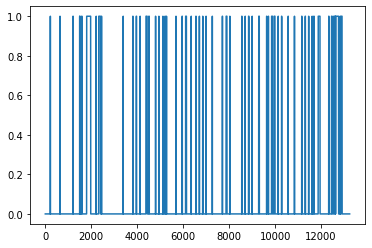

596-ws-training_processed.csv


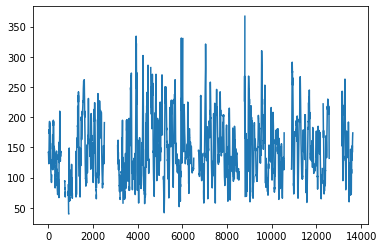

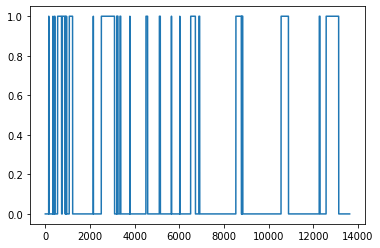

552-ws-training_processed.csv


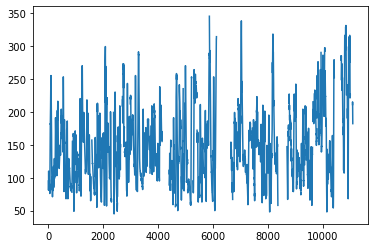

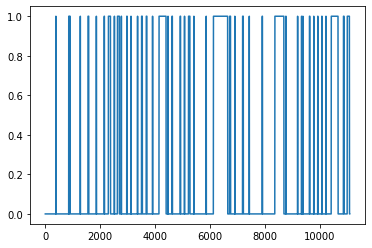

544-ws-training_processed.csv


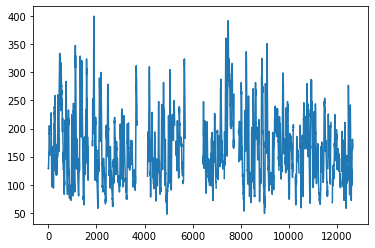

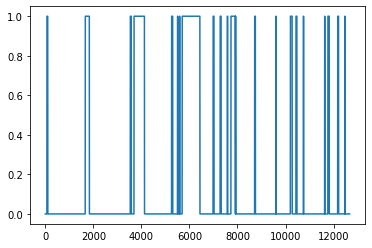

588-ws-training_processed.csv


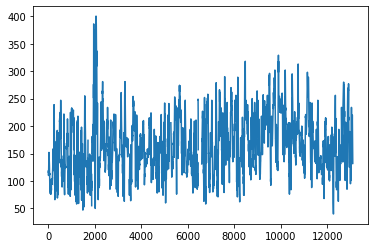

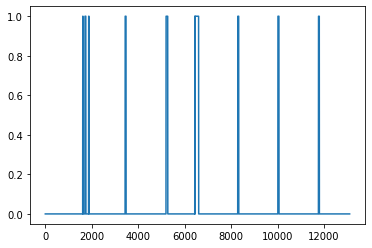

563-ws-training_processed.csv


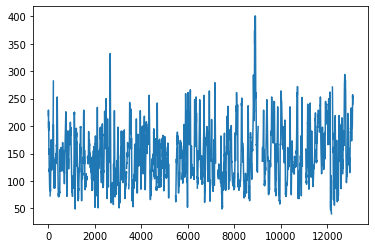

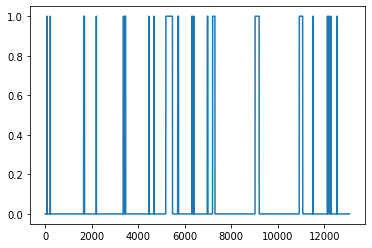

575-ws-training_processed.csv


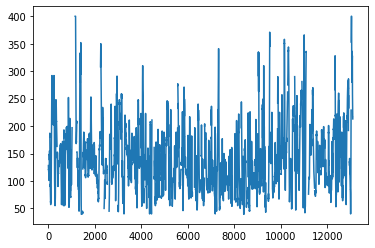

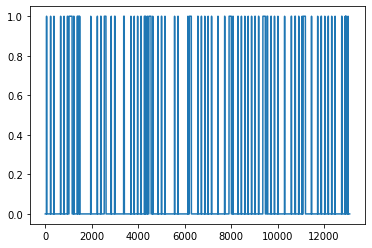

559-ws-training_processed.csv


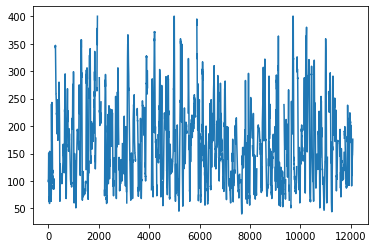

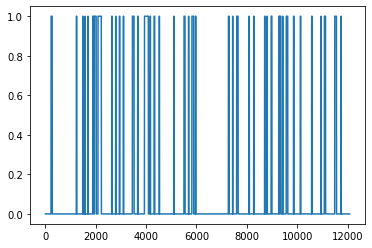

591-ws-training_processed.csv


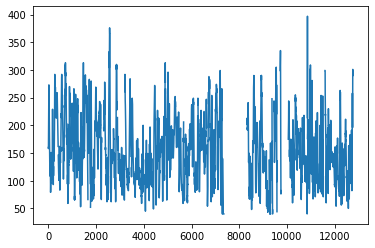

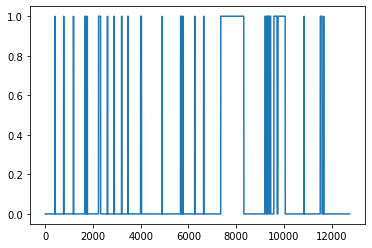

570-ws-training_processed.csv


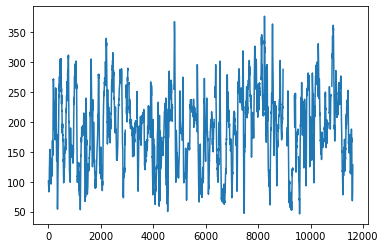

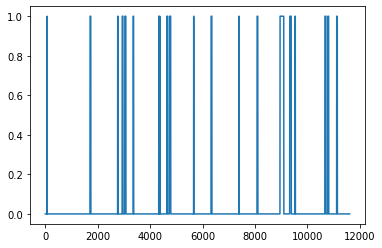

In [7]:
for key, df in df_list.items():
    print(key)
    plt.plot(df["cbg"].to_numpy())
    plt.show()
    plt.plot(df["missing_cbg"].to_numpy())
    plt.show()

* there are really sparse values like finger and carbInput, containing almost no data at all
* one could argue that removing them would be the best
* but i still believe that these values are important features for prediction (e.g. carbInput means the blood glucose value should increase)

# Dealing with missing values

* Another [paper](https://pubmed.ncbi.nlm.nih.gov/34770397/) used cubic splines in order to restore missing cbg samples
* Below you can see a cutout of patient 567 where the cbg values are missing
* when using cubic splines (or any other method) to interpolate the missing values, it is easy to see that new values are misleading
* Therefore we ignore them during training with masks
* For the other covariates: 
  * Columns like "finger" are really sparse and are therefore filled up with as an interpolation wouldn't make sense
  * The columns "Basal", "GSR", "HR" will be interpolated using cubic splines
* I decided to set the 'NA' values to just -1 to tell the network they are missing

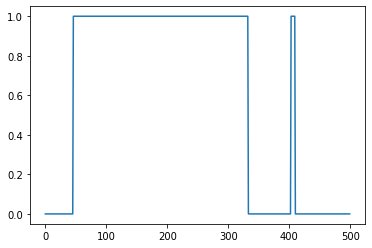

In [8]:

plt.plot(df_list["567-ws-training_processed.csv"]["missing_cbg"][1500:2000].to_numpy())


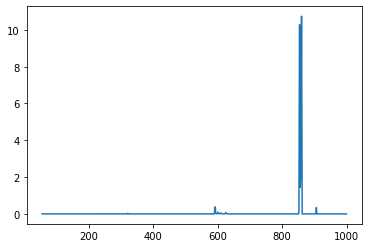

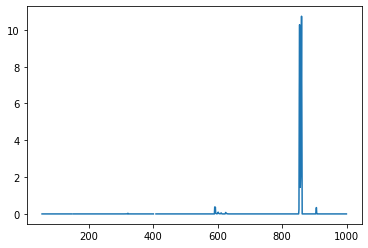

In [9]:
df = df_list["570-ws-training_processed.csv"].copy()
# other options: polynomial, linear, quadratic,...
df["gsr"] = df["gsr"].interpolate("cubic")
plt.plot(df["gsr"][:1000])
plt.show()
plt.plot(df_list["570-ws-training_processed.csv"]["gsr"][:1000])

# Other Preprocessing Steps

* Neural networks work better if the input values are normalized/standardized
* I decided that i scale every value between -0.5 and 0.5
* What to do if the dataset would have contained categorial values?
  * Every category would receive an index value
  * After indexing: i would have scaled the values between -0.5 and 0.5
* Alternative scaling methods: 
  * scaling between 0 and 1
  * standardizing, by setting the mean to zero and standard deviation to 0.5
* IMPORTANT(!!!) Scale according to train data, even when scaling val/test data, otherwise prediction willl be wrong

In [10]:
all_data.describe()

,5minute_intervals_timestamp,missing_cbg,cbg,finger,basal,hr,gsr,carbInput,bolus
count,1.530390e+05,153039.000000,134788.000000,3787.000000,151749.000000,70757.000000,117882.000000,1774.000000,2946.000000
mean,5.714297e+06,0.119257,158.948853,157.611566,1.000059,79.853682,0.859090,44.740699,5.989664
std,2.619589e+05,0.324092,60.717516,75.508538,0.417486,16.030767,3.392687,33.328517,4.382126
min,5.434415e+06,0.000000,40.000000,0.000000,0.000000,45.000000,0.000000,0.000000,0.000000
25%,5.463995e+06,0.000000,113.000000,106.000000,0.730000,67.000000,0.000089,20.000000,2.700000
50%,5.816776e+06,0.000000,151.000000,151.000000,0.980000,79.000000,0.010315,38.000000,5.000000
75%,6.025440e+06,0.000000,197.000000,203.000000,1.250000,90.000000,0.201129,60.000000,8.500000
max,6.048864e+06,1.000000,400.000000,586.000000,2.340000,189.000000,75.074359,450.000000,25.000000


# Correlations

* Find out which covariates are crucial when it comes to predicting 
* I do this by plotting covariates on x, and cbg on the y axis

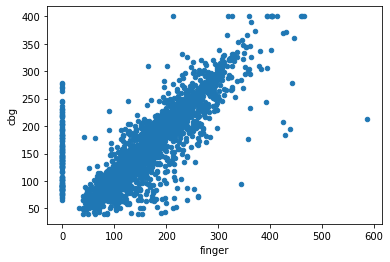

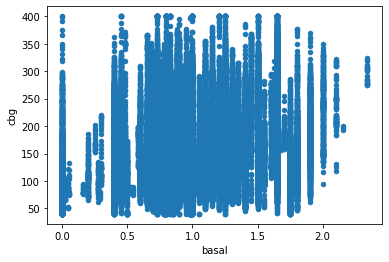

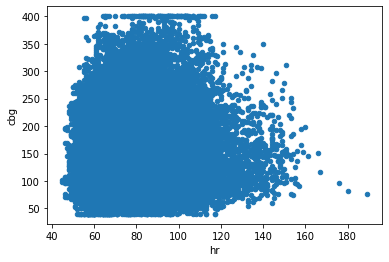

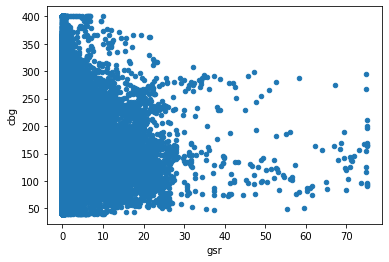

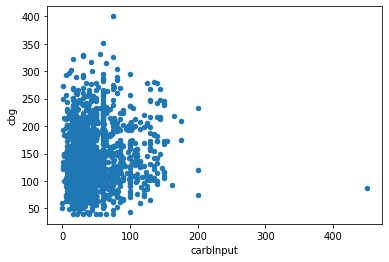

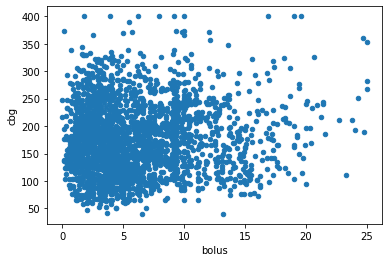

In [11]:
for col in cols:
    if col == "cbg" or col == "missing_cbg" or col == "5minute_intervals_timestamp":
        continue
    all_data[all_data[col].notnull()].plot.scatter(col, "cbg")

* There are only a few outliers (see carbInput and finger)
* When looking at the csv in this position, i cannot explain why these outliers exist
* Interesting is that the finger value should directly correlate to the actual cbg value, but there is a lot of deviation
* Outliers can be dealt with through regularization